*Luis Antonio Ortega Andrés    
Antonio Coín Castro*
# Métodos Avanzados en Aprendizaje Automático

In [1]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

%matplotlib inline

### Funciones auxiliares

In [2]:
def plotModel(x,y,clase,clf,title=""):
    from matplotlib.colors import ListedColormap
    
    x_min, x_max = x.min() - .2, x.max() + .2
    y_min, y_max = y.min() - .2, y.max() + .2
    hx = (x_max - x_min)/100.
    hy = (y_max - y_min)/100.
    xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

    separator= 0.0
    if hasattr(clf, "decision_function"):
        z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    elif hasattr(clf, "predict_proba"):
        z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        separator = 0.5
    else:
        z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    z = z.reshape(xx.shape)
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    plt.contourf(xx, yy, z, cmap=cm, alpha=.8)
    plt.contour(xx, yy, z, [separator], linewidths=[2], colors=['k'])

    if clase is not None:
        plt.scatter(x[clase==-1], y[clase==-1], c='#FF0000')
        plt.scatter(x[clase==1], y[clase==1], c='#0000FF')
    else:
        plt.plot(x,y,'g', linewidth=3)
        
    plt.gca().set_xlim(xx.min(), xx.max())
    plt.gca().set_ylim(yy.min(), yy.max())
    plt.grid(True)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)

In [3]:
def createDataSet(n, model, ymargin, noise=None, output_boundary=False):
    x = np.random.rand(n,1)*2.0*np.pi
    xbnd = np.linspace(0,2.0*np.pi,100)

    if model == 'sine':
        y = (np.random.rand(n,1) - 0.5)*2.2
        c = y > np.sin(x)
        ybnd = np.sin(xbnd)
    elif model == 'linear':
        y = np.random.rand(n,1)*2.0*np.pi
        c = y > x
        ybnd = xbnd
    elif model == 'square':
        y = np.random.rand(n,1)*4.0*np.pi*np.pi
        c = y > x*x
        ybnd = xbnd*xbnd
    else:
        y = np.random.rand(n,1)*2.0*np.pi
        c = y > x
        ybnd = xbnd
    
    y[c == True] = y[c == True] + ymargin
    y[c == False] = y[c == False] - ymargin
    
    if noise is not None:
        y = y + noise * np.random.randn(n,1)
        x = x + noise * np.random.randn(n,1)

    if output_boundary == True:
        return x, y, (c*1).ravel(), xbnd, ybnd
    else:
        return x, y, (c*1).ravel()

In [4]:
def plotData(x,y,c,style0,style1,title=''):
    plt.scatter(x[c==-1],y[c==-1],**style0)
    plt.scatter(x[c==1],y[c==1],**style1)
    plt.grid(True)
    plt.axis([x.min()-0.2, x.max()+0.2, y.min()-0.2, y.max()+0.2])
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)

## Gradient Boosting

$\DeclareMathOperator*{\argmin}{arg\,min}$

El algoritmo de Gradient Boosting persigue construir un clasificador *ensemble* mediante un modelo aditivo, es decir, como suma de clasificadores débiles (*weak classifiers*). La idea general es obtener un clasificador $F(x)$ de la forma

$$F(x)=\sum_{i=1}^M h_m(x),$$

de manera que realizamos una construcción iterativa en M pasos:

$$F_m(x)=F_{m-1}(x) + \gamma_mh_m(x), \quad m=1,\dots,M.$$

Los multiplicadores $\gamma_m$ son constantes que marcan el tamaño del paso y ponderan el peso de cada clasificador débil. El objetivo es optimizar los valores de $\gamma_m$ y $h_m$ para minimizar la pérdida entre las predicciones y los valores reales en el conjunto de entrenamiento, utilizando un esquema de gradiente descendente. De esta forma, definimos nuestro clasificador inicial como aquella constante que minimiza la función de pérdida.

Pasamos ahora a describir el algoritmo de Gradient Boosting:

**Entrada**: 

- Conjunto de entrenamiento $\{(x_n, y_n)\}_{n=1,\dots,N}$.
- Función de pérdida puntual diferenciable $L(y,F(x))$.
- Número de número de iteraciones $M$.

**Procedimiento**:

1. Se inicializa el modelo con un clasificador constante que minimice la pérdida esperada:
$$
F_0 (x) = \argmin_{\gamma \in \mathbb R} \sum_{n=1}^N L(y_n, \gamma).
$$
2. Para $m = 1,\dots,M$:
    1. Se calculan los *pseudo-residuos*:
    $$
        r_{nm} = - \left[ \frac{\partial L(y_n, F(x_n))}{\partial F(x_n)} \right]_{F(x) = F_{m-1}(x)} \quad n = 1,\dots,N.
    $$
    
    2. Se ajusta un modelo base $h_m(x)$ a los pseudo-residuos, es decir, se entrena $h_m$ sobre el conjunto $\{x_n, r_{nm}\}_{n=1,\dots,N}$.
    3. Se estima el multiplicador $\gamma_m$ que minimiza el error en entrenamiento, utilizando si es necesario un único paso del método de Newton-Raphson:
    $$
    \gamma_m = \argmin_\gamma \sum_{n=1}^N L(y_n, F_{m-1}(x_n) + \gamma h_m(x_n)).
    $$
    4. Se actualiza el modelo:
    $$
    F_m(x) =F_{m-1}(x) + \gamma_m h_m(x).
    $$
    
3. Devolvemos $F_M(x)$ como modelo final en el caso de regresión, o alguna transformación de la misma para clasificación, que transforme valores continuos en etiquetas de clase teniendo en cuenta cuál es la función de pérdida.

Aunque el algoritmo descrito arriba representa el procedimiento estándar de construcción de estimadores, podemos añadir un par de técnicas de regularización para intentar prevenir el *overfitting*:

1. **Learning rate.** Ponderamos la contribución de cada clasificador débil por un valor $0 < \nu \leq 1$, de forma que
$$F_{m}(x)=F_{m-1}(x) + \nu\gamma_mh_m(x)$$

2. **Stochastic Gradient Boosting.** Se trata de una modificación propuesta por J. Friedman ([paper](https://statweb.stanford.edu/~jhf/ftp/stobst.pdf)) en la que en cada etapa se utiliza una fracción de los datos para calcular los residuos, entrenar el clasificador débil y calcular los multiplicadores.

### Error cuadrático

Para el caso de regresión utilizamos como función de pérdida el error cuadrático entre predicciones y valores reales (convenientemente dividido entre 2 para simplificar los cálculos):

$$
L(y, F(x)) = \frac{1}{2}(y - F(x))^2.
$$

Veamos ahora con detalle cuáles son los elementos que modelan el algoritmo en este caso.

1. **Estimador inicial**. El valor que minimiza la pérdida cuadrática coincide con la media de las respuestas de los datos de entrenamiento:
$$
F_0(x) = \argmin_\gamma \sum_{n=1}^N L(y_n, \gamma) = \argmin_\gamma \sum_{n=1}^N (y_n - \gamma)^2
$$
$$
\dfrac{\partial \sum_{n=1}^N L(y_n, \gamma)}{\partial \gamma} = -\sum_{n=1}^N(y_n - \gamma) = 0 \implies F_0(x) = \frac{1}{N}\sum_{n=1}^N y_n = \bar{y}.
$$

2. **Pseudo-residuos**. Como la función de pérdida es derivable, podemos calcular explícitamente su derivada parcial respecto de la segunda variable:
$$
r_{nm} = - \left[ \frac{\partial L(y_n, F(x_n))}{\partial F(x_n)} \right]_{F(x) = F_{m-1}(x)} = -\left[ \frac{\partial}{\partial F(x_n)}\frac{1}{2}(y_n - F(x_n)^2 \right]_{F(x) = F_{m-1}(x)} = y_n - F_{m-1}(x_n).$$

3. **Multiplicador**. Queremos minimizar en $\gamma$ la siguiente función:
$$
f_m(\gamma) = \sum_{n=1}^N \frac{1}{2}(y_n - F_{m-1}(x_n) - \gamma h_m(x_n))^2
$$
Para ello, pretendemos calcular su derivada e igualarla a $0$. En primer lugar, se tiene:
$$
f_m'(\gamma) = \sum_{n=1}^N -h_m(x_n)(y_n - F_{m-1}(x_n) - \gamma h_m(x_n)) 
$$
Ahora, como $h_m$ se ha entrenado para que
$$
h_m(x_n) \approx r_{nm} = y_n- F_{m-1}(x_n),
$$
podemos aproximar:
$$
f_m'(\gamma) = \sum_{n=1}^N - (y_n- F_{m-1}(x_n))(y_n- F_{m-1}(x_n) - \gamma (y_n- F_{m-1}(x_n))) = (\gamma - 1) \sum_{n=1}^N (y_n- F_{m-1}(x_n))^2.
$$
Por tanto, concluimos que:
$$
f_m'(\gamma)= 0 \implies \gamma_m^* = 1.$$

Teniendo todo esto en cuenta, creamos una clase que represente estos elementos para la pérdida cuadrática.

In [5]:
class SquaredErrorLoss:
    """ 
    Define elementos para la función de pérdida cuadrática.
    """
    
    def F0(_, X, y):
        """ Calcula el valor constate que minimiza la pérdida con la salida 'y'. 
            Para la pérdida cuadrática este valor coincide con la media de los 
            valores de 'y'. """
        
        return np.mean(y)

    def residuals(_, y, F):
        """ Calcula los pseudo-residuos para un objetivo 'y' y 
            una salida del modelo 'F'. """

        return y - F

    def newton_step(_, X, y, residuals, hm):
        """ Recibe el conjunto de entrenamiento ('X'), el valor a predecir ('y'), 
            los pseudo-residuos ('residuals')  sobre los que se entrena el nuevo 
            regresor, y el propio regresor ('hm'). Calcula el multiplicador 
            asociado al paso m. """
        
        return 1.0
    
    def __call__(self, y, F):
        """ Devuelve el valor puntual de la función de pérdida para un 
            objetivo 'y' y una salida del modelo F. """
        
        return np.linalg.norm(y - F) ** 2

### Error logístico

Hacemos el mismo análisis para el caso de clasificación, utilizando como función de pérdida el error logístico:

$$
L(y, F(x)) = \log(1 + e^{-2yF(x)}), \quad y \in \{-1,1\}.
$$

En este caso la estrategia será un poco distinta, pues aprovecharemos que los estimadores débiles que usamos son árboles de decisión de profundidad $J$, es decir, de la forma 

$$h_m(x)=\sum_{j=1}^{J} b_{jm}\mathcal{I}(x \in R_{jm}),$$

donde $\mathcal I(\cdot)$ es la función indicadora y $\{R_{jm}\}_{j=1,\dots,J}$ son las regiones en las que se divide el espacio de entrada, representadas por las hojas terminales del árbol en el paso $m$-ésimo. En este caso, podemos mejorar la calidad del ajuste calculando un multiplicador diferente en cada nodo, es decir, construyendo los estimadores como

$$F_m(x) = F_{m-1}(x) + \sum_{j=1}^{J} \gamma_{jm}\mathcal{I}(x \in R_{jm}).$$

Notamos que, esto es equivalente a "descartar" los valores $\{b_{jm}\}$ del árbol de decisión y considerar que los multiplicadores son $\gamma_{jm}=\rho_m b_{jm}$, donde $\rho_m$ serían los multiplicadores a nivel de árbol que usaríamos siguiendo el algoritmo general. Por último, teniendo en cuenta que las regiones $\{R_{jm}\}$ son disjuntas, concluimos que

$$\gamma_{jm}= \argmin_\gamma \sum_{x_n \in R_{jm}} L(y_n, F_{m-1}(x_n)+\gamma). $$

Veamos entonces cómo serían los pasos del algoritmo:

1. **Estimador inicial**. En este caso, <a href="#Análisis-matemático-de-la-pérdida-logarítmica">se puede demostrar</a> que el valor del estimador constante inicial es:
$$
F_0(x)=\argmin_\gamma \sum_{n=1}^N L(y_n, \gamma) = \argmin_\gamma \sum_{n=1}^N \log(1 + e^{-2y_nF(x_n)}) = \frac{1}{2}\log \left(\frac{1+\bar{y}}{1-\bar y}\right).
$$

2. **Pseudo-residuos**. Se tiene que:
$$
r_{nm} = - \left[ \frac{\partial L(y_n, F(x_n))}{\partial F(x_n)} \right]_{F(x) = F_{m-1}(x)} = -\left[ \frac{\partial \log(1 + e^{-2y_nF(x_n)})}{\partial F(x_n)} \right]_{F(x) = F_{m-1}(x)} = \frac{2y_n e^{-2y_nF_{m-1}(x_n)}}{1 + e^{-2y_nF_{m-1}(x_n)}} = \frac{2y_n}{1 + e^{2y_nF_{m-1}(x_n)}}, \quad n = 1,\dots, N.
$$

3. **Multiplicador**. Queremos minimizar en $\gamma$ las siguientes funciones:
$$
f_j(\gamma) = \sum_{x_n \in R_{jm}}L(y_n, F_{m-1}(x_n) + \gamma) = \sum_{x_n \in R_{jm}}\log\left(1 + e^{-2y_n(F_{m-1}(x_n) + \gamma)}\right), \quad j = 1,\dots, J.$$
Como este problema de optimización es complicado, aproximamos el valor del mínimo estimando la raíz de su derivada mediante un único paso del método de Newton-Rhapson, con condición inicial $\gamma=0$:
$$
f_{jm}'(\gamma) = \sum_{x_n \in R_{jm}} \frac{-2y_n  e^{-2y_n(F_{m-1}(x_n)+\gamma)}}{1 + e^{-2y_n(F_{m-1}(x_n)+\gamma)}} = \sum_{x_n \in R_{jm}} \frac{-2y_n}{1 + e^{2y_n(F_{m-1}(x_n)+\gamma)}},
$$
$$
f_{jm}''(\gamma) = \sum_{x_n \in R_{jm}} \frac{4y_n^2e^{2y_n(F_{m-1}(x_n)+\gamma)}}{\left(1 + e^{2y_n(F_{m-1}(x_n)+\gamma)}\right)^2}.
$$
Por tanto, se tiene que:
$$
\gamma_{jm}^{*} = -\frac{f_{jm}'(\gamma = 0)}{f_{jm}''(\gamma = 0)} = \dfrac{\displaystyle \sum_{x_n \in R_{jm}}r_{nm}}{\displaystyle \sum_{x_n \in R_{jm}} \dfrac{2y_ne^{2y_nF_{m-1}(x_n)}2y_n}{(1 + e^{2y_nF_{m-1}(x_n)})(1+e^{2y_nF_{m-1}(x_n)})}}.
$$
Ahora, de la fórmula de $r_{nm}$ deducimos que $e^{2y_nF_{m-1}(x_n)}=\frac{-2y_n-r_{nm}}{r_{nm}}$, y teniendo en cuenta que $y_n\in \{-1, 1\}$, llegamos a que
$$
\gamma_{jm}^{*} =\dfrac{\displaystyle \sum_{x_n \in R_{jm}} r_{nm}}{\displaystyle \sum_{x_n \in R_{jm}}|r_{nm}|(2-|r_{nm}|)}.
$$

4. **Transformación de la salida a etiquetas.** Como esta pérdida la usamos para resolver un problema de clasificación, debemos transformar la salida de nuestro regresor $F_M$ en etiquetas de clase. Para ello utilizamos la función *sigmoide*, adaptada convenientemente para el caso en que las etiquetas son $\pm 1$:
$$
\hat \sigma(x)=\frac{1}{1 + e^{-2x}}
$$
De nuevo, <a href="#Análisis-matemático-de-la-pérdida-logarítmica">se puede demostrar</a> que la transformación 
$$
F_M(x) \mapsto \hat \sigma(F_M(x))
$$
transforma la salida en una probabilidad entre $0$ y $1$, de forma que nuestro modelo final queda como
$$
P(y=1\mid x)=\hat \sigma(F_M(x)).
$$
De esta forma, para cada nuevo ejemplo $x$ daremos como predicción la clase $\hat y(x)\in\{-1, 1\}$ que verifique 
$$P(y=\hat y\mid x)\ge P(y\neq \hat y\mid x).$$ Dada la simetría entre las etiquetas, y en vista de que la función sigmoide es creciente y toma el valor $0.5$ en $x=0$, tenemos finalmente que esto equivale a
$$
\hat y(x)=\operatorname{signo}(F_M(x)).
$$

*Nota*: no aplicamos esta estrategia en el caso de la pérdida cuadrática porque no proporciona un nuevo algoritmo; el clasificador final seguiría siendo el mismo.

In [6]:
class LogLoss:
    """ 
    Define elementos para la función de pérdida logarítmica.
    """
    
    def F0(_, X, y):
        """ Calcula el valor constate que minimiza la pérdida con la salida 'y'. """
        
        ybar = np.mean(y)
        
        return 0.5 * np.log((1.0 + ybar) / (1.0 - ybar))

    def residuals(_, y, F):
        """ Calcula los pseudo-residuos para un objetivo 'y' y 
            una salida del modelo 'F'. """

        return (2.0 * y) / (1 + np.exp(2.0 * y * F))

    def newton_step(_, X, y, residuals, hm):
        """ Recibe el conjunto de entrenamiento ('X'), el valor a predecir ('y'), 
            los pseudo-residuos ('residuals')  sobre los que se entrena el nuevo 
            regresor, y el propio regresor ('hm'). Calcula el multiplicador 
            asociado al paso m. """
        
        rabs = np.abs(residuals)
        X_leaves = hm.apply(X)
        
        # Compute numerator and denominator
        numerator = [np.sum(residuals[X_leaves == j]) for j in np.unique(X_leaves)]
        denominator = np.array([np.sum(rabs[X_leaves == j] * (2.0 - rabs[X_leaves == j])) 
                                  for j in np.unique(X_leaves)])
        denominator[denominator < 1e-16] = 0.0  # prevent division by zero and overflow
        
        # Compute multipliers
        mult = numerator / denominator
        
        return np.array(mult)
    
    def raw_preds_to_proba(self, y):
        """ Transforma las predicciones 'y' del regresor final F_M en
            probabilidades de clase {-1, 1}, aplicando una sigmoide. """
        
        proba = np.ones((y.shape[0], 2), dtype = np.float64)
        proba[:, 1] = 1.0 / (1.0 + np.exp(-2.0 * y))
        proba[:, 0] -= proba[:, 1]
        
        return proba
        
    def raw_preds_to_labels(self, y):
        """ Transforma las predicciones 'y' del regresor final F_M en
            etiquetas de clase {-1, 1}, tomando el signo. """
        
        labels = np.sign(y)
        labels[labels == 0] = 1  # np.sign(0)=0
        
        return labels
    
    def __call__(self, y, F):
        """ Devuelve el valor puntual de la función de pérdida para un 
            objetivo 'y' y una salida del modelo F. """
        
        return np.log(1 + np.exp(-2.0 * y * F))

### Implementación de Gradient Boosting

In [7]:
class BaseGB():
    def __init__(self, n_estimators, learning_rate, loss, 
                 max_depth, subsample, random_state):
        self.n_estimators_  = n_estimators
        self.random_state   = random_state
        self.max_depth      = max_depth
        self.learning_rate  = learning_rate
        self.subsample      = subsample
        self.loss_          = loss
        self.estimators_    = []
        self.multipliers    = []
        
    def _update_F(self, mult, X, hm):
        raise NotImplementedError('_update_F method not implemented')
    
    def fit(self, X, y): 
        n = X.shape[0]
        self.n_features_ = X.shape[1]
        
        if self.subsample < 1.0:
            np.random.seed(self.random_state)
        
        # Get initial constant estimator 
        self.F0 = self.loss_.F0(X, y)
        
        # Set initial mask
        sample_mask = np.arange(n)
        n_inbag = int(self.subsample * n)
        if n_inbag == 0:
            raise ValueError(f"Empty training set after selecting a fraction of {self.subsample} out of {n}")
        
        # Loop trough iterations
        F = np.full(n, self.F0)
        for m in range(self.n_estimators_):
            # Set base tree learner with desired depth
            hm = DecisionTreeRegressor(criterion = "mse",
                                       max_depth = self.max_depth, 
                                       random_state = self.random_state)
            
            # Select training subset for this iteration
            if self.subsample < 1.0:
                sample_mask = np.random.choice(n, size = n_inbag, replace = False)
            
            # Get pseudo-residuals from loss function
            r = self.loss_.residuals(y[sample_mask], F[sample_mask])
            
            # Fit base learner to pseudo-residuals
            hm.fit(X[sample_mask, :], r)
            
            # Compute multipliers
            mult = self.loss_.newton_step(X[sample_mask], y[sample_mask], r, hm)
            
            # Save multipliers and predictions for this step
            self.multipliers.append(mult)
            self.estimators_.append(hm)
            
            # Update F
            F += self.learning_rate * self._update_F(mult, X, hm)
            
        return self
    
    def raw_predict(self, X, stages = None):
        F = np.full(X.shape[0], self.F0)
        if stages is None:
            stages = self.n_estimators_
            
        for m in range(stages):
            F += self.learning_rate \
                   * self._update_F(self.multipliers[m], X,
                                    self.estimators_[m])
                
        return F
    
    def predict(self, X):
        raise NotImplementedError('predict method not implemented')

    def score(self, X, y):
        raise NotImplementedError('score method not implemented')

In [8]:
class RegressorGB(BaseGB):
    def __init__(self, n_estimators = 100, loss = SquaredErrorLoss(), 
                 learning_rate = 0.1, max_depth = 3, subsample = 1.0, 
                 random_state = 2020):
        super().__init__(n_estimators, learning_rate, loss, 
                         max_depth, subsample, random_state)
        
    def _update_F(self, mult, X, hm):
        pred = hm.predict(X)
        
        return mult * pred
    
    def predict(self, X):
        return self.raw_predict(X)
    
    def predict_staged(self, X):
        for m in range(self.n_estimators_):
            yield self.raw_predict(X, stages = m)
            
    def score(self, X, y):
        return SquaredErrorLoss()(y, self.predict(X))

In [9]:
class ClassifierGB(BaseGB):
    def __init__(self, n_estimators = 100, loss = LogLoss(), 
                 learning_rate = 0.1, max_depth = 3, subsample = 1.0, 
                 random_state = 2020):
        super().__init__(n_estimators, learning_rate, loss, 
                         max_depth, subsample, random_state)
        
    def _update_F(self, mult, X, hm):
        # Get regions for each sample
        X_leaves = hm.apply(X)
        u = np.unique(X_leaves)

        d = dict(zip(u, np.arange(len(u))))
        
        return mult[np.vectorize(d.get)(X_leaves)]
    
    def fit(self, X, y):
        # Check class labels 
        classes = np.unique(y)
        if (classes != [-1, 1]).any():
            raise ValueError('Binary class labels must be [-1, 1]')
        self.classes_ = classes
        
        # Fit model
        super().fit(X, y)
        
        return self
    
    def decision_function(self, X):
        return self.raw_predict(X)
    
    def predict(self, X):
        raw_predictions = self.raw_predict(X)
        
        return self.loss_.raw_preds_to_labels(raw_predictions)
    
    def predict_staged(self, X):
        for m in range(self.n_estimators_):
            yield self.loss_.raw_preds_to_labels(self.raw_predict(X, stages = m))
        
    def predict_proba(self, X):
        raw_predictions = self.raw_predict(X)
        
        return self.loss_.raw_preds_to_proba(raw_predictions)
    
    def score(self, X, y):
        """ Calcula el accuracy de la predicción. """
        
        return np.mean(self.predict(X) == y)

### Casos de prueba

In [41]:
np.random.seed(11)
n = 50
model = 'sine'
ymargin = 0
noise = 0.2

# We are using the same points for regresion and clawsification. 
# For regresion we use (x, y) and for classification ((x,y), c).
Xtrain_reg, Ytrain_reg, Ytrain_class, = createDataSet(n, model, ymargin, noise)
Xtest_reg, Ytest_reg, Ytest_class = createDataSet(5 * n, model, ymargin, noise)

Xtrain_class = np.concatenate((Xtrain_reg, Ytrain_reg), axis = 1)
Xtest_class = np.concatenate((Xtest_reg, Ytest_reg), axis = 1)
Ytrain_reg = Ytrain_reg.ravel()
Ytrain_class[Ytrain_class == 0] = -1
Ytest_class[Ytest_class == 0] = -1

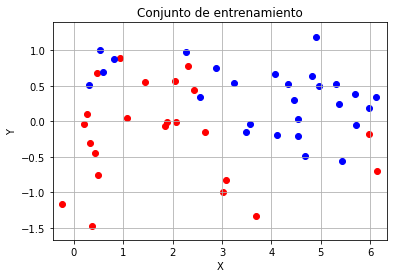

In [43]:
plotData(Xtrain_reg, Ytrain_reg, Ytrain_class, {'c':'#FF0000'},{'c':'#0000FF'})
plt.title("Conjunto de entrenamiento")
_ = plt.plot()

#### Regresión

In [44]:
gb = RegressorGB()
gb.fit(Xtrain_reg, Ytrain_reg)

print(f"Training MSE: {gb.score(Xtrain_reg, Ytrain_reg)}")
print(f"Test MSE: {gb.score(Xtest_reg, Ytest_reg)}")

Training MSE: 0.9181678236547842
Test MSE: 46632.05117535146


In [45]:
from sklearn.ensemble import GradientBoostingRegressor

gb_sk = GradientBoostingRegressor(criterion="mse", random_state=2020)
gb_sk.fit(Xtrain_reg, Ytrain_reg)

print(f"Training MSE sklearn: {SquaredErrorLoss()(Ytrain_reg, gb_sk.predict(Xtrain_reg))}")
print(f"Test MSE sklearn: {SquaredErrorLoss()(Ytest_reg, gb_sk.predict(Xtest_reg))}")

Training MSE sklearn: 0.9181678236547842
Test MSE sklearn: 46632.05117535146


#### Clasificación

Training accuracy: 1.0
Test accuracy: 0.896


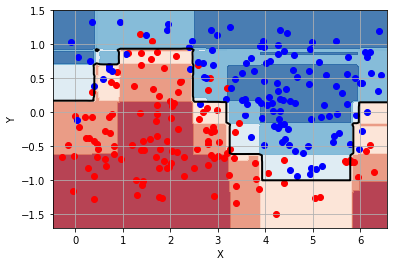

In [52]:
gbc = ClassifierGB()
gbc.fit(Xtrain_class, Ytrain_class)

print(f"Training accuracy: {gbc.score(Xtrain_class, Ytrain_class)}")
print(f"Test accuracy: {gbc.score(Xtest_class, Ytest_class)}")

plotModel(Xtest_reg, Ytest_reg, Ytest_class, gbc)

Training accuracy: 1.0
Test accuracy: 0.896


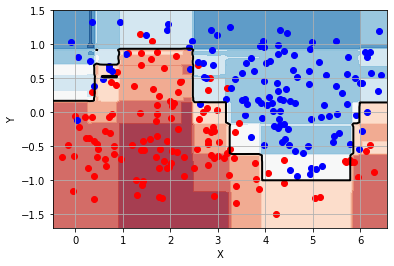

In [53]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyRegressor

gbc_sk = GradientBoostingClassifier(criterion="mse", random_state=2020)
gbc_sk.fit(Xtrain_class, Ytrain_class)
print(f"Training accuracy: {gbc_sk.score(Xtrain_class, Ytrain_class)}")
print(f"Test accuracy: {gbc_sk.score(Xtest_class, Ytest_class)}")

plotModel(Xtest_reg, Ytest_reg, Ytest_class, gbc_sk)

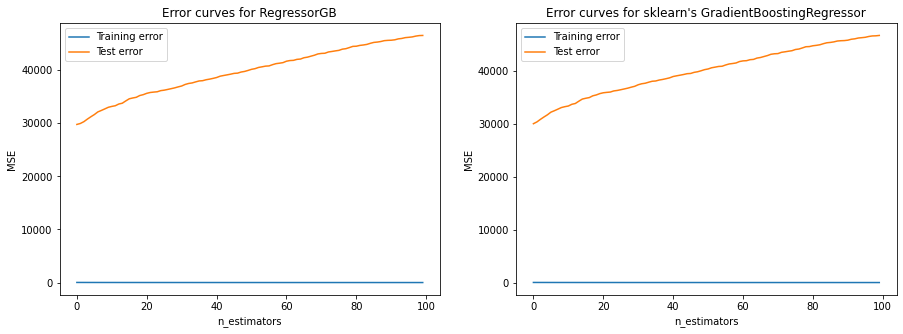

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

Fs_train = [Fm for Fm in gb.predict_staged(Xtrain_reg)]
Fs_error_train = [SquaredErrorLoss()(Ytrain_reg, Fm) for Fm in Fs_train]
Fs_test = [Fm for Fm in gb.predict_staged(Xtest_reg)]
Fs_error_test = [SquaredErrorLoss()(Ytest_reg, Fm) for Fm in Fs_test]
axs[0].plot(np.arange(100), Fs_error_train, label = "Training error")
axs[0].plot(np.arange(100), Fs_error_test, label = "Test error")
axs[0].legend()
axs[0].set_title("Error curves for RegressorGB")
axs[0].set_xlabel("n_estimators")
axs[0].set_ylabel("MSE")

Fs_train = [Fm for Fm in gb_sk.staged_predict(Xtrain_reg)]
Fs_error_train = [SquaredErrorLoss()(Ytrain_reg, Fm) for Fm in Fs_train]
Fs_test = [Fm for Fm in gb_sk.staged_predict(Xtest_reg)]
Fs_error_test = [SquaredErrorLoss()(Ytest_reg, Fm) for Fm in Fs_test]
axs[1].plot(np.arange(100), Fs_error_train, label = "Training error")
axs[1].plot(np.arange(100), Fs_error_test, label = "Test error")
axs[1].legend()
axs[1].set_title("Error curves for sklearn's GradientBoostingRegressor")
axs[1].set_xlabel("n_estimators")
axs[1].set_ylabel("MSE")
plt.show()

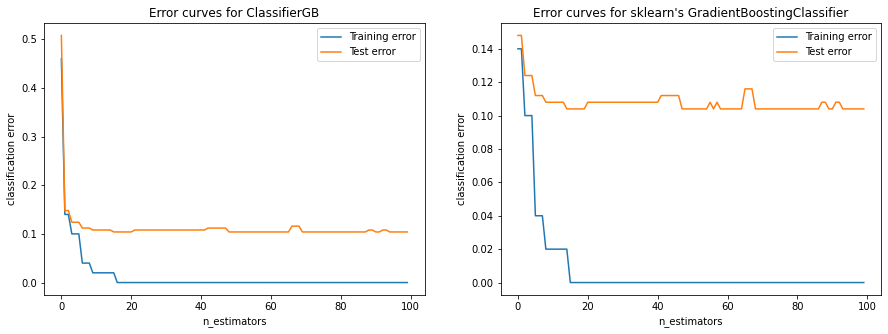

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

Fs_train = [Fm for Fm in gbc.predict_staged(Xtrain_class)]
Fs_error_train = [np.mean(Ytrain_class != Fm) for Fm in Fs_train]
Fs_test = [Fm for Fm in gbc.predict_staged(Xtest_class)]
Fs_error_test = [np.mean(Ytest_class != Fm) for Fm in Fs_test]
axs[0].plot(np.arange(100), Fs_error_train, label = "Training error")
axs[0].plot(np.arange(100), Fs_error_test, label = "Test error")
axs[0].legend()
axs[0].set_title("Error curves for ClassifierGB")
axs[0].set_xlabel("n_estimators")
axs[0].set_ylabel("classification error")

Fs_train = [Fm for Fm in gbc_sk.staged_predict(Xtrain_class)]
Fs_error_train = [np.mean(Ytrain_class != Fm) for Fm in Fs_train]
Fs_test = [Fm for Fm in gbc_sk.staged_predict(Xtest_class)]
Fs_error_test = [np.mean(Ytest_class != Fm) for Fm in Fs_test]
axs[1].plot(np.arange(100), Fs_error_train, label = "Training error")
axs[1].plot(np.arange(100), Fs_error_test, label = "Test error")
axs[1].legend()
axs[1].set_title("Error curves for sklearn's GradientBoostingClassifier")
axs[1].set_xlabel("n_estimators")
axs[1].set_ylabel("classification error")
plt.show()

**TODO**

- Comentar clases BaseGB, RegressorGB y ClassifierGB.
- Comentar dataset, pruebas y resultados.
- Hacer CV con n_estimators + regularización y encontrar los parámetros óptimos.
- Hacer análisis matemático.

## Análisis matemático de la pérdida logarítmica

- ¿Por qué usamos la pérdida log para clasificación (adaptada a $\pm 1$)? (binary cross-entropy, max log-likelihood)
- ¿Por qué usamos sigmoide? Se elige primero sigmoide y luego logloss o al revés?
- Deducción de $F_0$ (log-odds)
- Por qué se puede usar $\sigma(F(x))$ para recuperar la probabilidad de $y=1$.

https://stats.stackexchange.com/questions/340546/likelihood-function-for-binomial-distribution-with-label-1-and-1

https://stats.stackexchange.com/questions/280049/derive-a-particular-expression-for-binomial-deviance-from-elements-of-statistica

https://scikit-learn.org/stable/modules/model_evaluation.html#log-loss

\+ 2 Papers, libro de ESLR 